In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-13 17:14:35.995108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-13 17:14:35.995140: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
dateparse = lambda x: datetime.strptime(x, '%d-%b-%y')
df = pd.read_csv('../data_region.csv', parse_dates=['date'], date_parser=dateparse)
df = df.set_index('date')

In [4]:
df1 = df.loc["2015-02-01":"2016-09-01"]
df2 = df.loc["2016-03-01":"2017-09-30"]
df3 = df.loc["2017-09-01":"2019-04-02"]

In [5]:
df1.index[0].strftime('%A'), df2.index[0].strftime('%A'), df3.index[0].strftime('%A')

('Sunday', 'Tuesday', 'Friday')

In [6]:
df1.index[-1].strftime('%A'), df2.index[-1].strftime('%A'), df3.index[-1].strftime('%A')

('Thursday', 'Saturday', 'Tuesday')

### Create batches of training data (12 months)

In [7]:
def split_sequence(sequence, sequence_total, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence_total[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit MLP model 

In [8]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(Dense(250, activation='relu', input_shape=(n_steps_in,)))
    model.add(Dense(250, activation='relu', 
                kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3),
                bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=400, verbose=1, callbacks=[callback])
    
    loss_per_epoch = model.history.history['loss']
    plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
    return model 

In [9]:
def train_predict(dataset, dataset_total, test, actual):
    n_steps_in, n_steps_out, slide = 7, 7, 1
    X, y = split_sequence(dataset, dataset_total, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))
    
    model = fit(X, y, n_input, n_output)
    
    x_input = dataset[-n_steps_in:]
    x_input = x_input.reshape((1, n_input, 1))
    pred = model.predict(x_input)
    
    mae, rmse, mape = list(), list(), list()  
    for i in range(0, len(test), n_steps_in):
        mae_aux, rmse_aux, mape_aux = measure_error(actual, pred[0], n_steps_in, i)
        mae.append(mae_aux), rmse.append(rmse_aux), mape.append(mape_aux)
        #print(actual[i:i+n_steps_in], pred[0], mae, rmse, mape)
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        pred = model.predict(x_input)
    
    return mae, rmse, mape

In [10]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [11]:
def measure_error(actual, pred, step, index):
    #print(actual[index:index+step], pred)
    mae = mean_absolute_error(array(actual[index:index+step]), pred)
    rmse = np.sqrt(mean_squared_error(array(actual[index:index+step]), pred))
    smape = sMAPE(array(actual[index:index+step]), pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

2022-10-13 17:14:39.426445: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-13 17:14:39.426501: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-13 17:14:39.426915: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/400
16/16 [==============================] - 1s 8ms/step - loss: 4666052.0000
Epoch 2/400
16/16 [==============================] - 0s 7ms/step - loss: 378385.1562
Epoch 3/400
16/16 [==============================] - 0s 7ms/step - loss: 95667.5938
Epoch 4/400
16/16 [==============================] - 0s 7ms/step - loss: 44742.1914
Epoch 5/400
16/16 [==============================] - 0s 9ms/step - loss: 36782.1289
Epoch 6/400
16/16 [==============================] - 0s 7ms/step - loss: 35613.0156
Epoch 7/400
16/16 [==============================] - 0s 10ms/step - loss: 35715.7266
Epoch 8/400
16/16 [==============================] - 0s 8ms/step - loss: 36487.9141
Epoch 9/400
16/16 [==============================] - 0s 6ms/step - loss: 35932.4023
Epoch 10/400
16/16 [==============================] - 0s 8ms/step - loss: 35469.1211
Epoch 11/400
16/16 [==============================] - 0s 7ms/step - loss: 35370.3789
Epoch 12/400
16/16 [==============================] - 0s 7ms/step - lo

16/16 [==============================] - 0s 7ms/step - loss: 31906.1641
Epoch 98/400
16/16 [==============================] - 0s 7ms/step - loss: 30502.2617
Epoch 99/400
16/16 [==============================] - 0s 6ms/step - loss: 32230.8262
Epoch 100/400
16/16 [==============================] - 0s 8ms/step - loss: 31553.4082
Epoch 101/400
16/16 [==============================] - 0s 8ms/step - loss: 30832.4336
Epoch 102/400
16/16 [==============================] - 0s 9ms/step - loss: 30807.5801
Epoch 103/400
16/16 [==============================] - 0s 12ms/step - loss: 30197.3926
Epoch 104/400
16/16 [==============================] - 0s 8ms/step - loss: 29996.2168
Epoch 105/400
16/16 [==============================] - 0s 6ms/step - loss: 30248.7480
Epoch 106/400
16/16 [==============================] - 0s 7ms/step - loss: 30344.3223
Epoch 107/400
16/16 [==============================] - 0s 8ms/step - loss: 31894.4941
Epoch 108/400
16/16 [==============================] - 0s 11ms/step -

16/16 [==============================] - 0s 4ms/step - loss: 30976.1660
Epoch 193/400
16/16 [==============================] - 0s 6ms/step - loss: 30609.8496
Epoch 194/400
16/16 [==============================] - 0s 5ms/step - loss: 30032.7637
Epoch 195/400
16/16 [==============================] - 0s 5ms/step - loss: 30563.3340
Epoch 196/400
16/16 [==============================] - 0s 5ms/step - loss: 30930.1836
Epoch 197/400
16/16 [==============================] - 0s 5ms/step - loss: 30285.8242
Epoch 198/400
16/16 [==============================] - 0s 5ms/step - loss: 30537.6621
Epoch 199/400
16/16 [==============================] - 0s 5ms/step - loss: 29698.7148
Epoch 200/400
16/16 [==============================] - 0s 4ms/step - loss: 29920.5371
Epoch 201/400
16/16 [==============================] - 0s 4ms/step - loss: 29588.7070
Epoch 202/400
16/16 [==============================] - 0s 5ms/step - loss: 30816.1328
Epoch 203/400
16/16 [==============================] - 0s 5ms/step -

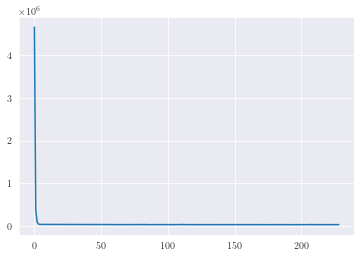

In [12]:
df1 = df1.pivot_table('count', 'date', 'region')
df1['Total'] = df1.sum(axis=1)
dataset = df1[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']].values
dataset_total = df1[['Total']].values
mae1, rmse1, smape1 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df1[['Total']][509:].values)

Epoch 1/400
16/16 [==============================] - 1s 8ms/step - loss: 4456248.5000
Epoch 2/400
16/16 [==============================] - 0s 8ms/step - loss: 473031.5625
Epoch 3/400
16/16 [==============================] - 0s 12ms/step - loss: 126628.7812
Epoch 4/400
16/16 [==============================] - 0s 8ms/step - loss: 55530.8320
Epoch 5/400
16/16 [==============================] - 0s 9ms/step - loss: 49643.2734
Epoch 6/400
16/16 [==============================] - 0s 8ms/step - loss: 47521.0859
Epoch 7/400
16/16 [==============================] - 0s 8ms/step - loss: 47671.5469
Epoch 8/400
16/16 [==============================] - 0s 11ms/step - loss: 47624.0586
Epoch 9/400
16/16 [==============================] - 0s 8ms/step - loss: 46992.6289
Epoch 10/400
16/16 [==============================] - 0s 8ms/step - loss: 46295.1133
Epoch 11/400
16/16 [==============================] - 0s 7ms/step - loss: 46490.7891
Epoch 12/400
16/16 [==============================] - 0s 9ms/step - 

16/16 [==============================] - 0s 7ms/step - loss: 42161.9023
Epoch 98/400
16/16 [==============================] - 0s 7ms/step - loss: 42525.2422
Epoch 99/400
16/16 [==============================] - 0s 7ms/step - loss: 42285.4023
Epoch 100/400
16/16 [==============================] - 0s 8ms/step - loss: 44052.8867
Epoch 101/400
16/16 [==============================] - 0s 7ms/step - loss: 42223.1367
Epoch 102/400
16/16 [==============================] - 0s 9ms/step - loss: 42098.8633
Epoch 103/400
16/16 [==============================] - 0s 8ms/step - loss: 42672.1406
Epoch 104/400
16/16 [==============================] - 0s 8ms/step - loss: 42315.7812
Epoch 105/400
16/16 [==============================] - 0s 7ms/step - loss: 42380.6406
Epoch 106/400
16/16 [==============================] - 0s 7ms/step - loss: 41600.6914
Epoch 107/400
16/16 [==============================] - 0s 7ms/step - loss: 42190.5938
Epoch 108/400
16/16 [==============================] - 0s 8ms/step - l

16/16 [==============================] - 0s 8ms/step - loss: 41510.0039
Epoch 193/400
16/16 [==============================] - 0s 7ms/step - loss: 42053.1445
Epoch 194/400
16/16 [==============================] - 0s 6ms/step - loss: 42097.5469
Epoch 195/400
16/16 [==============================] - 0s 8ms/step - loss: 42085.9766
Epoch 196/400
16/16 [==============================] - 0s 7ms/step - loss: 41734.8047
Epoch 197/400
16/16 [==============================] - 0s 8ms/step - loss: 43116.3203
Epoch 198/400
16/16 [==============================] - 0s 7ms/step - loss: 40589.5469
Epoch 199/400
16/16 [==============================] - 0s 8ms/step - loss: 42053.8242
Epoch 200/400
16/16 [==============================] - 0s 8ms/step - loss: 41553.1680
Epoch 201/400
16/16 [==============================] - 0s 7ms/step - loss: 41778.4844
Epoch 202/400
16/16 [==============================] - 0s 7ms/step - loss: 41703.2031
Epoch 203/400
16/16 [==============================] - 0s 6ms/step -

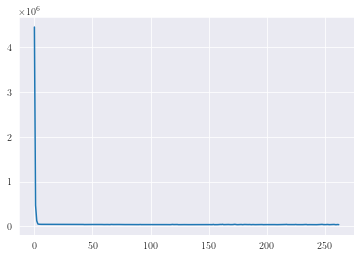

In [13]:
df2 = df2.pivot_table('count', 'date', 'region')
df2['Total'] = df2.sum(axis=1)
dataset = df2[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']].values
dataset_total = df2[['Total']].values
mae2, rmse2, smape2 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df2[['Total']][509:].values)

Epoch 1/400
16/16 [==============================] - 1s 8ms/step - loss: 4187238.5000
Epoch 2/400
16/16 [==============================] - 0s 7ms/step - loss: 421093.1250
Epoch 3/400
16/16 [==============================] - 0s 8ms/step - loss: 146745.9688
Epoch 4/400
16/16 [==============================] - 0s 7ms/step - loss: 100158.7500
Epoch 5/400
16/16 [==============================] - 0s 8ms/step - loss: 92230.1484
Epoch 6/400
16/16 [==============================] - 0s 7ms/step - loss: 89818.0156
Epoch 7/400
16/16 [==============================] - 0s 7ms/step - loss: 90992.5234
Epoch 8/400
16/16 [==============================] - 0s 6ms/step - loss: 91364.1797
Epoch 9/400
16/16 [==============================] - 0s 7ms/step - loss: 90888.1094
Epoch 10/400
16/16 [==============================] - 0s 7ms/step - loss: 93702.2422
Epoch 11/400
16/16 [==============================] - 0s 7ms/step - loss: 90071.0156
Epoch 12/400
16/16 [==============================] - 0s 8ms/step - l

16/16 [==============================] - 0s 7ms/step - loss: 77943.0859
Epoch 98/400
16/16 [==============================] - 0s 8ms/step - loss: 79018.7109
Epoch 99/400
16/16 [==============================] - 0s 7ms/step - loss: 79862.5078
Epoch 100/400
16/16 [==============================] - 0s 7ms/step - loss: 78861.6016
Epoch 101/400
16/16 [==============================] - 0s 9ms/step - loss: 80189.1719
Epoch 102/400
16/16 [==============================] - 0s 8ms/step - loss: 80108.8281
Epoch 103/400
16/16 [==============================] - 0s 8ms/step - loss: 78997.9609
Epoch 104/400
16/16 [==============================] - 0s 8ms/step - loss: 79333.7578
Epoch 105/400
16/16 [==============================] - 0s 8ms/step - loss: 79009.6406
Epoch 106/400
16/16 [==============================] - 0s 9ms/step - loss: 85828.1484
Epoch 107/400
16/16 [==============================] - 0s 9ms/step - loss: 80445.8906
Epoch 108/400
16/16 [==============================] - 0s 7ms/step - l

16/16 [==============================] - 0s 8ms/step - loss: 75947.3828
Epoch 193/400
16/16 [==============================] - 0s 9ms/step - loss: 74245.9375
Epoch 194/400
16/16 [==============================] - 0s 8ms/step - loss: 75204.9688
Epoch 195/400
16/16 [==============================] - 0s 9ms/step - loss: 75577.7812
Epoch 196/400
16/16 [==============================] - 0s 7ms/step - loss: 72089.7109
Epoch 197/400
16/16 [==============================] - 0s 5ms/step - loss: 74900.4219
Epoch 198/400
16/16 [==============================] - 0s 5ms/step - loss: 75094.6094
Epoch 199/400
16/16 [==============================] - 0s 6ms/step - loss: 80888.6953
Epoch 200/400
16/16 [==============================] - 0s 5ms/step - loss: 80448.4297
Epoch 201/400
16/16 [==============================] - 0s 6ms/step - loss: 76443.5469
Epoch 202/400
16/16 [==============================] - 0s 6ms/step - loss: 77187.7266
Epoch 203/400
16/16 [==============================] - 0s 5ms/step -

16/16 [==============================] - 0s 6ms/step - loss: 69174.7266
Epoch 288/400
16/16 [==============================] - 0s 6ms/step - loss: 69381.4375
Epoch 289/400
16/16 [==============================] - 0s 6ms/step - loss: 68939.7266
Epoch 290/400
16/16 [==============================] - 0s 6ms/step - loss: 70125.2812
Epoch 291/400
16/16 [==============================] - 0s 5ms/step - loss: 72411.2188
Epoch 292/400
16/16 [==============================] - 0s 6ms/step - loss: 72474.7109
Epoch 293/400
16/16 [==============================] - 0s 6ms/step - loss: 68573.3359
Epoch 294/400
16/16 [==============================] - 0s 5ms/step - loss: 77272.8516
Epoch 295/400
16/16 [==============================] - 0s 5ms/step - loss: 68025.0391
Epoch 296/400
16/16 [==============================] - 0s 6ms/step - loss: 69341.8203
Epoch 297/400
16/16 [==============================] - 0s 6ms/step - loss: 70652.7109
Epoch 298/400
16/16 [==============================] - 0s 7ms/step -

16/16 [==============================] - 0s 5ms/step - loss: 68534.7578
Epoch 383/400
16/16 [==============================] - 0s 4ms/step - loss: 65101.2852
Epoch 384/400
16/16 [==============================] - 0s 4ms/step - loss: 67330.6250
Epoch 385/400
16/16 [==============================] - 0s 6ms/step - loss: 66019.4141
Epoch 386/400
16/16 [==============================] - 0s 5ms/step - loss: 70995.4688
Epoch 387/400
16/16 [==============================] - 0s 5ms/step - loss: 70569.6875
Epoch 388/400
16/16 [==============================] - 0s 5ms/step - loss: 67147.3516
Epoch 389/400
16/16 [==============================] - 0s 5ms/step - loss: 67031.2812
Epoch 390/400
16/16 [==============================] - 0s 5ms/step - loss: 68971.9922
Epoch 391/400
16/16 [==============================] - 0s 5ms/step - loss: 67722.6328
Epoch 392/400
16/16 [==============================] - 0s 5ms/step - loss: 68778.0703
Epoch 393/400
16/16 [==============================] - 0s 5ms/step -

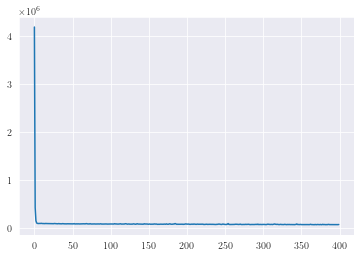

In [14]:
df3 = df3.pivot_table('count', 'date', 'region')
df3['Total'] = df3.sum(axis=1)
dataset = df3[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']].values
dataset_total = df3[['Total']].values
mae3, rmse3, smape3 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df3[['Total']][509:].values)

In [15]:
mae = mae1 + mae2 + mae3
rmse = rmse1 + rmse2 + rmse3
smape = smape1 + smape2 + smape3

### Calculate Error

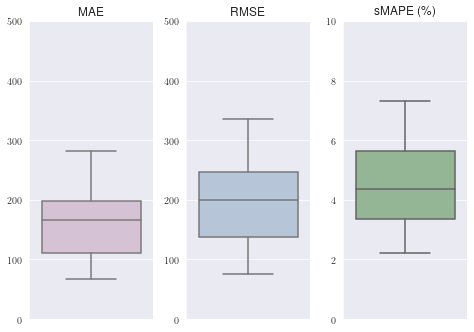

In [16]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 500))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 500))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 10))
plt.tight_layout()

In [18]:
emer_mlp_day_region = [mae,rmse,smape]
%store emer_mlp_day_region

Stored 'emer_mlp_day_region' (list)
